In [313]:
# Alejandro Flores Hernández 1709458
# Marc Dalmau Guamis 1710713

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    make_scorer,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt

In [314]:
cotxes = "Cars_Data_6k.csv"
dftrain = pd.read_csv(cotxes)


Estadísticas descriptivas:
       Unnamed: 0         Year            KM           CV       Length  \
count  5973.00000  5973.000000  5.973000e+03  5973.000000  5973.000000   
mean   2986.00000  2018.005190  8.169198e+04   133.583124     4.348507   
std    1724.40091     3.672202  5.705450e+04    48.986934     0.397570   
min       0.00000  2000.000000  5.000000e+00    20.000000     0.000000   
25%    1493.00000  2016.000000  4.620100e+04   102.000000     4.140000   
50%    2986.00000  2019.000000  7.483600e+04   125.000000     4.360000   
75%    4479.00000  2021.000000  1.088270e+05   150.000000     4.520000   
max    5972.00000  2024.000000  1.116416e+06   498.000000     6.840000   

             Width       Height       Weight        Trunk         Vmax  \
count  5964.000000  5969.000000  5953.000000  4613.000000  5815.000000   
mean      1.800342     1.566710  1387.058458  1334.004336   191.217713   
std       0.112896     0.184844   240.581446   375.613298    20.536075   
min      

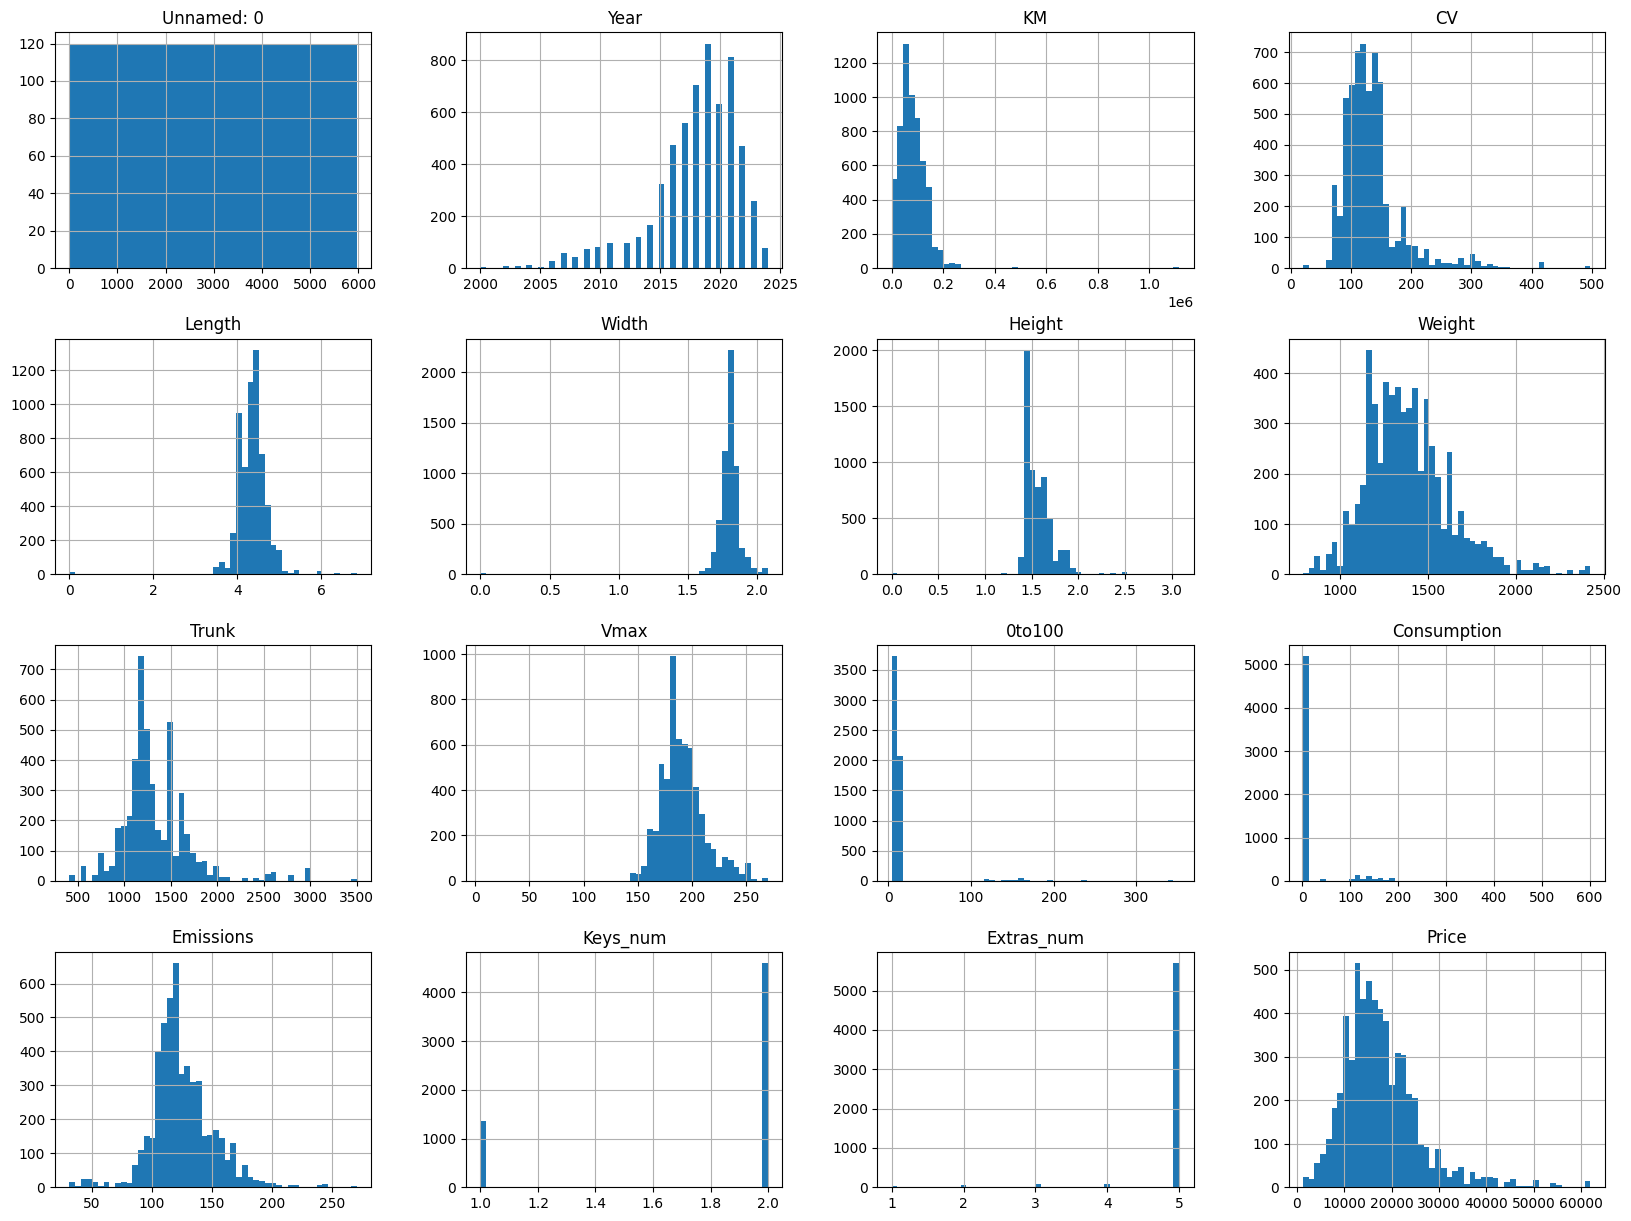

In [315]:
print("\nEstadísticas descriptivas:")
print(dftrain.describe())
#grafic de les dades en histograma
dftrain.hist(bins=50, figsize=(20,15))
plt.show()

In [316]:
#veiem que hi ha columnes amb -s que representen valors nuls
#les substituim per NaN
dftrain.replace("-", np.nan, inplace=True)

C:\Users\aleja\AppData\Local\Temp\ipykernel_24028\562233532.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dftrain.replace("-", np.nan, inplace=True)


In [317]:
# Mirem si hi ha nans a les dades de train

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)
#treiem tank ja que esta buida sencera
dftrain = dftrain.drop(columns=["Tank"])



Percentatge de dades del train que falten per variable:

Tank            100.000000
Trunk            22.769128
Location         18.951950
Emissions        14.716223
Consumption       3.047045
Vmax              2.645237
0to100            0.435292
Sticker           0.418550
Weight            0.334840
Width             0.150678
Height            0.066968
KM                0.000000
Name              0.000000
Brand             0.000000
Unnamed: 0        0.000000
Year              0.000000
CV                0.000000
Fuel              0.000000
Length            0.000000
Transmission      0.000000
One_owner         0.000000
Keys_num          0.000000
Extras_num        0.000000
Price             0.000000
dtype: float64


In [318]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from collections import Counter

# Copia del dataframe
df = dftrain.copy()

# -------------------------
# 1. IMPUTACIÓ NUMÈRICA amb KNN
# -------------------------

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df[num_cols])

imputer_num = KNNImputer(n_neighbors=5)
X_num_imputed_scaled = imputer_num.fit_transform(X_num_scaled)
X_num_imputed = scaler.inverse_transform(X_num_imputed_scaled)

df[num_cols] = X_num_imputed


# -------------------------
# 2. IMPUTACIÓ STICKER (moda)
# -------------------------

df["Sticker"] = df["Sticker"].fillna(df["Sticker"].mode()[0])


# -------------------------
# 3. IMPUTACIÓ LOCATION (KNN CORRECTE)
# -------------------------

# Variables que faran servir per buscar veïns (només numèriques)
X_num = df[num_cols].values

# Escalem per fer distàncies correctes
X_scaled = scaler.fit_transform(X_num)

# Per cada fila mancant en Location
loc_missing_idx = df["Location"].isna()

for idx in np.where(loc_missing_idx)[0]:

    # Distància a TOTES les altres files
    dists = np.sqrt(np.sum((X_scaled - X_scaled[idx])**2, axis=1))
    
    # Ordenem per distància i agafem els k=5 veïns més propers (excloent ell mateix)
    nn_idx = np.argsort(dists)[1:6]

    # Categories dels veïns
    neighbor_cats = df.iloc[nn_idx]["Location"].dropna()

    # Assignem la moda dels veïns
    if len(neighbor_cats) > 0:
        df.at[idx, "Location"] = Counter(neighbor_cats).most_common(1)[0][0]
    else:
        # Si tots veïns tenen també NA → assignem "Missing" com a fallback segur
        df.at[idx, "Location"] = "Missing"


# -------------------------
# 4. RESULTATS
# -------------------------

print(df.isnull().sum())

dftrain = df.copy()


Unnamed: 0      0
Brand           0
Name            0
Sticker         0
Year            0
KM              0
Fuel            0
CV              0
Transmission    0
One_owner       0
Location        0
Length          0
Width           0
Height          0
Weight          0
Trunk           0
Vmax            0
0to100          0
Consumption     0
Emissions       0
Keys_num        0
Extras_num      0
Price           0
dtype: int64


In [319]:
"""
# UNA ALTRA MANERA DE ELIMINAR ELS NANS


#numeriques amb pocs NaNs → mitjana
num_pocs_nans = ["Consumption", "Vmax", "0to100", "Weight", "Width", "Height"]

for col in num_pocs_nans:
    dftrain[col].fillna(dftrain[col].mean(), inplace=True)

#categoriquees amb pocs NaNs → moda
cat_pocs_nans = ["Sticker"]   
for col in cat_pocs_nans:
    mode_val = dftrain[col].mode()
    fill_val = mode_val[0] if not mode_val.empty else "Unknown"
    dftrain[col].fillna(fill_val, inplace=True)

"""

'\n# UNA ALTRA MANERA DE ELIMINAR ELS NANS\n\n\n#numeriques amb pocs NaNs → mitjana\nnum_pocs_nans = ["Consumption", "Vmax", "0to100", "Weight", "Width", "Height"]\n\nfor col in num_pocs_nans:\n    dftrain[col].fillna(dftrain[col].mean(), inplace=True)\n\n#categoriquees amb pocs NaNs → moda\ncat_pocs_nans = ["Sticker"]   \nfor col in cat_pocs_nans:\n    mode_val = dftrain[col].mode()\n    fill_val = mode_val[0] if not mode_val.empty else "Unknown"\n    dftrain[col].fillna(fill_val, inplace=True)\n\n'

In [320]:
print(dftrain.head())

   Unnamed: 0    Brand            Name Sticker    Year       KM      Fuel  \
0         0.0     Opel      Opel Corsa       C  2022.0  47707.0    Diésel   
1         1.0  Peugeot  Peugeot Rifter       C  2019.0  57194.0    Diésel   
2         2.0  Renault  Renault Kadjar       C  2017.0  66428.0    Diésel   
3         3.0    Dacia   Dacia Sandero       C  2016.0  48430.0  Gasolina   
4         4.0   Nissan  Nissan QASHQAI       C  2020.0  72209.0  Gasolina   

      CV Transmission  One_owner  ... Height  Weight   Trunk   Vmax  0to100  \
0  102.0       MANUAL       True  ...   1.43  1165.0  1069.0  188.0    10.2   
1  130.0         AUTO       True  ...   1.82  1430.0  1355.0  179.0     4.3   
2  110.0       MANUAL      False  ...   1.61  1380.0  1478.0  182.0    11.9   
3   75.0       MANUAL       True  ...   1.52   941.0  1200.0  162.0    14.5   
4  160.0         AUTO      False  ...   1.59  1315.0  1598.0  198.0     9.9   

   Consumption  Emissions  Keys_num  Extras_num    Price  
0  

In [321]:
"""# Pasem a numèriques les variables categòriques
sticker = LabelEncoder()
fuel = LabelEncoder()
transmission = LabelEncoder()
owner = LabelEncoder()
name= LabelEncoder()
brand= LabelEncoder()   
location = LabelEncoder()
#pasem de dades categoriques a numeriques
dftrain["Sticker"] = sticker.fit_transform(dftrain["Sticker"])
dftrain["Fuel"] = fuel.fit_transform(dftrain["Fuel"])
dftrain["Transmission"] = transmission.fit_transform(dftrain["Transmission"])
dftrain["One_owner"] = owner.fit_transform(dftrain["One_owner"])
dftrain["Name"] = name.fit_transform(dftrain["Name"])
dftrain["Brand"] = brand.fit_transform(dftrain["Brand"])
dftrain["Location"] = location.fit_transform(dftrain["Location"])"""

'# Pasem a numèriques les variables categòriques\nsticker = LabelEncoder()\nfuel = LabelEncoder()\ntransmission = LabelEncoder()\nowner = LabelEncoder()\nname= LabelEncoder()\nbrand= LabelEncoder()   \nlocation = LabelEncoder()\n#pasem de dades categoriques a numeriques\ndftrain["Sticker"] = sticker.fit_transform(dftrain["Sticker"])\ndftrain["Fuel"] = fuel.fit_transform(dftrain["Fuel"])\ndftrain["Transmission"] = transmission.fit_transform(dftrain["Transmission"])\ndftrain["One_owner"] = owner.fit_transform(dftrain["One_owner"])\ndftrain["Name"] = name.fit_transform(dftrain["Name"])\ndftrain["Brand"] = brand.fit_transform(dftrain["Brand"])\ndftrain["Location"] = location.fit_transform(dftrain["Location"])'

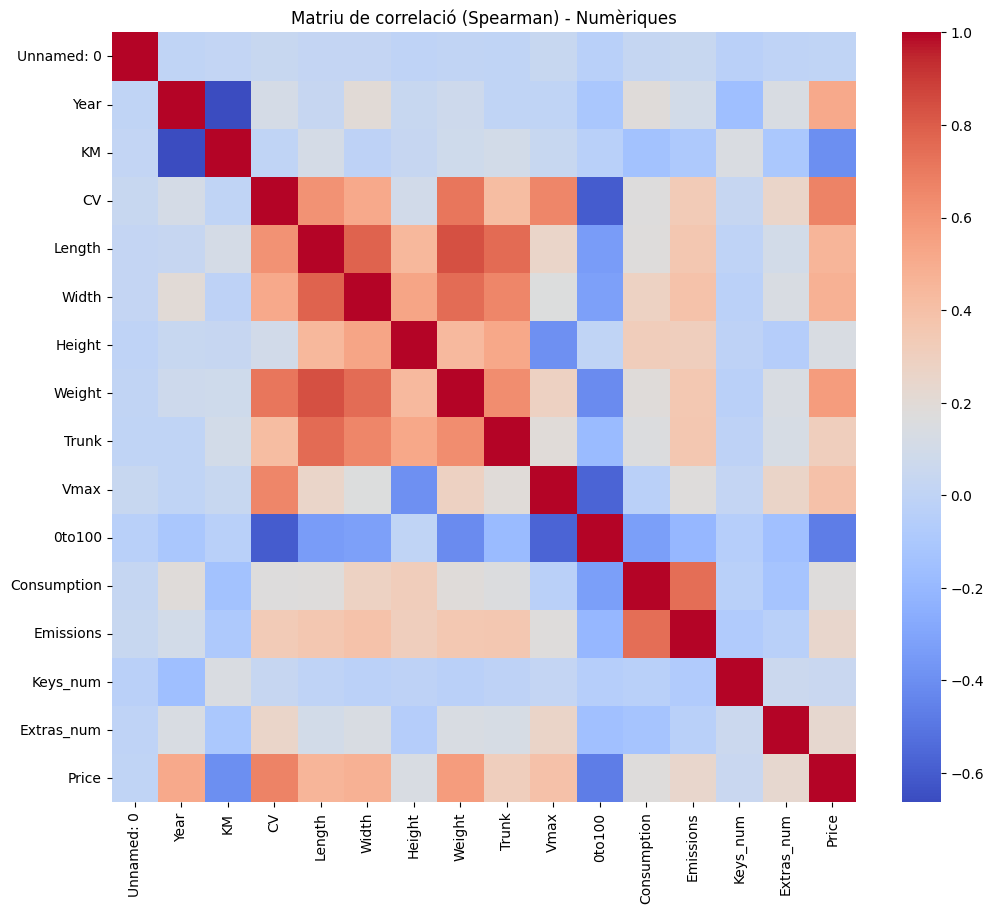

Correlació combinada amb Price:
Price           1.000000
Name            0.839347
CV              0.674583
Weight          0.573670
Brand           0.525604
Year            0.517169
Transmission    0.490125
Width           0.476452
Length          0.459216
Vmax            0.391121
Sticker         0.369124
Trunk           0.310719
Fuel            0.293703
Emissions       0.244075
Location        0.237634
Extras_num      0.229306
Consumption     0.179618
Height          0.141091
Keys_num        0.048869
Unnamed: 0      0.000368
KM             -0.403095
0to100         -0.470578
dtype: float64


In [322]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# 1️⃣ Separar variables
# -------------------------
num_cols = dftrain.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = dftrain.select_dtypes(include=["object"]).columns.tolist()

# -------------------------
# 2️⃣ Correlació Spearman (numèriques)
# -------------------------
corr_num = dftrain[num_cols].corr(method="spearman")

# Correlació amb Price
corr_price_num = corr_num["Price"].sort_values(ascending=False)

# Opcional: heatmap de correlacions numèriques
plt.figure(figsize=(12,10))
sns.heatmap(corr_num, cmap="coolwarm", annot=False)
plt.title("Matriu de correlació (Spearman) - Numèriques")
plt.show()

# -------------------------
# 3️⃣ Correlation Ratio (categòriques)
# -------------------------
def correlation_ratio(categories, values):
    """Correlació entre variable categòrica i numèrica (Price)"""
    categories = np.array(categories)
    values = np.array(values)
    cat_levels = np.unique(categories)
    
    total_mean = np.mean(values)
    numerator = sum([
        len(values[categories==cat]) * (np.mean(values[categories==cat]) - total_mean)**2
        for cat in cat_levels
    ])
    denominator = sum((values - total_mean)**2)
    
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

corr_cat = {}
for col in cat_cols:
    corr_cat[col] = correlation_ratio(dftrain[col], dftrain["Price"])

# Ordenar
corr_cat = dict(sorted(corr_cat.items(), key=lambda item: item[1], reverse=True))

# -------------------------
# 4️⃣ Combinar numèriques i categòriques
# -------------------------
series_num = pd.Series(corr_price_num)
series_cat = pd.Series(corr_cat)

corr_combined = pd.concat([series_num, series_cat])
corr_combined = corr_combined.sort_values(ascending=False)

print("Correlació combinada amb Price:")
print(corr_combined)


In [323]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.base import clone

# ---------- VARIABLES ----------
num_cols = [
    "Year", "KM", "CV", "Length", "Width", "Height", "Weight",
    "Trunk", "Vmax", "0to100", "Consumption", "Emissions",
    "Keys_num", "Extras_num"
]

cat_ohe_cols = ["Sticker", "Fuel", "Transmission"]
cat_te_cols = ["Brand", "Name", "Location"]

bool_cols = dftrain.select_dtypes(include=[bool]).columns.tolist()
dftrain["One_owner"] = dftrain["One_owner"].astype(int)


# ---------- TARGET ENCODING AMB CROSS-VALIDATION ----------
df_te = dftrain.copy()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for col in cat_te_cols:
    df_te[col + "_TE"] = np.nan

for train_idx, val_idx in kf.split(df_te):
    train_fold = df_te.iloc[train_idx]
    val_fold = df_te.iloc[val_idx]
    
    for col in cat_te_cols:
        means = train_fold.groupby(col)["Price"].mean()
        df_te.loc[df_te.index[val_idx], col + "_TE"] = val_fold[col].map(means)

# En cas de categories rares → substituir per la mitjana global
global_mean = dftrain["Price"].mean()
for col in cat_te_cols:
    df_te[col + "_TE"].fillna(global_mean, inplace=True)

te_cols_new = [c + "_TE" for c in cat_te_cols]


# ---------- ONE-HOT ENCODING ----------
ohe = OneHotEncoder(drop="first", sparse_output=False)
ohe_array = ohe.fit_transform(df_te[cat_ohe_cols])
ohe_cols = ohe.get_feature_names_out(cat_ohe_cols)
df_ohe = pd.DataFrame(ohe_array, columns=ohe_cols, index=df_te.index)


# ---------- ESCALAT ----------
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_te[num_cols])
df_scaled = pd.DataFrame(scaled_array, columns=num_cols, index=df_te.index)


# ---------- CONCATENAR TOT ----------
df_final = pd.concat([
    df_scaled,
    df_ohe,
    df_te[te_cols_new],
    df_te[bool_cols],
    df_te["Price"]
], axis=1)

# ---------- DEFINIR X i y ----------
X = df_final.drop(columns=["Price"])
y = df_final["Price"]

print("Shape final:", X.shape)
print(df_final.head())


Shape final: (5973, 28)
       Year        KM        CV    Length     Width    Height    Weight  \
0  1.087942 -0.595708 -0.644779 -0.725735 -0.269508 -0.739005 -0.924807   
1  0.270926 -0.429414 -0.073151  0.129531  0.439627  1.362167  0.176627   
2 -0.273752 -0.267556 -0.481457  0.255306  0.350985  0.230767 -0.031190   
3 -0.546091 -0.583035 -1.195993 -0.725735 -0.624076 -0.254119 -1.855830   
4  0.543264 -0.166223  0.539309  0.104376  0.085059  0.123014 -0.301353   

      Trunk      Vmax    0to100  ...  Fuel_GNC  Fuel_Gasolina  Fuel_Híbrido  \
0 -0.713341 -0.123165 -0.141901  ...       0.0            0.0           0.0   
1  0.005873 -0.554348 -0.365804  ...       0.0            0.0           0.0   
2  0.315185 -0.410620 -0.077386  ...       0.0            0.0           0.0   
3 -0.383911 -1.368804  0.021283  ...       0.0            1.0           0.0   
4  0.616953  0.355927 -0.153285  ...       0.0            1.0           0.0   

   Fuel_Híbrido Enchufable  Transmission_MANUAL   

C:\Users\aleja\AppData\Local\Temp\ipykernel_24028\2801268164.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_te[col + "_TE"].fillna(global_mean, inplace=True)


In [324]:
"""
categorical_cols = ["Sticker", "Fuel", "Transmission", "Name", "Brand", "Location"]

dftrain = pd.get_dummies(dftrain, columns=categorical_cols, drop_first=True)

#print(dftrain.head())

bool_cols = dftrain.select_dtypes(include='bool').columns
# Pasem a numèriques totes les variables True/False
dftrain[bool_cols] = dftrain[bool_cols].astype(int)

# Comprovem
print(dftrain[bool_cols].head())

"""

'\ncategorical_cols = ["Sticker", "Fuel", "Transmission", "Name", "Brand", "Location"]\n\ndftrain = pd.get_dummies(dftrain, columns=categorical_cols, drop_first=True)\n\n#print(dftrain.head())\n\nbool_cols = dftrain.select_dtypes(include=\'bool\').columns\n# Pasem a numèriques totes les variables True/False\ndftrain[bool_cols] = dftrain[bool_cols].astype(int)\n\n# Comprovem\nprint(dftrain[bool_cols].head())\n\n'

In [325]:
"""print("Correspondències valors de la variable Sticker:\n")
for i, cat in enumerate(sticker.classes_):
    print(i, "->", cat)

print("\nCorrespondències valors de la variable Fuel:\n")
for i, cat in enumerate(fuel.classes_):
    print(i, "->", cat)

print("\nCorrespondències valors de la variable Transmission:\n")
for i, cat in enumerate(transmission.classes_):
    print(i, "->", cat)

print("\nCorrespondències valors de la variable One_owner:\n")
for i, cat in enumerate(owner.classes_):
    print(i, "->", cat)"""


'print("Correspondències valors de la variable Sticker:\n")\nfor i, cat in enumerate(sticker.classes_):\n    print(i, "->", cat)\n\nprint("\nCorrespondències valors de la variable Fuel:\n")\nfor i, cat in enumerate(fuel.classes_):\n    print(i, "->", cat)\n\nprint("\nCorrespondències valors de la variable Transmission:\n")\nfor i, cat in enumerate(transmission.classes_):\n    print(i, "->", cat)\n\nprint("\nCorrespondències valors de la variable One_owner:\n")\nfor i, cat in enumerate(owner.classes_):\n    print(i, "->", cat)'

In [326]:
"""
#grafic de les dades en histograma
df_final.hist(bins=50, figsize=(20,15))
plt.show()
"""

'\n#grafic de les dades en histograma\ndf_final.hist(bins=50, figsize=(20,15))\nplt.show()\n'

In [327]:
"""

#normalitzem les dades
scaler = StandardScaler()

#deixem fora les columnes que no cal normalitzar
cols_to_scale=[
    "Year",
    "KM",
    "CV",
    "Length",
    "Width",
    "Height",
    "Weight",
    "Trunk",
    "Vmax",
    "0to100",
    "Consumption",
    "Emissions",
    "Keys_num",
    "Extras_num",
    "brand_mean_price",
    "brand_max_price",
    "brand_min_price",
    "model_mean_price",
    "model_max_price",
    "model_min_price",
]


df_scaled_values = scaler.fit_transform(dftrain[cols_to_scale])
df_scaled = pd.DataFrame(df_scaled_values, columns=cols_to_scale, index=df.index)
df_final = pd.concat([df_scaled,dftrain[bool_cols],dftrain["Price"]], axis=1)
print(df_final.head())

"""

'\n\n#normalitzem les dades\nscaler = StandardScaler()\n\n#deixem fora les columnes que no cal normalitzar\ncols_to_scale=[\n    "Year",\n    "KM",\n    "CV",\n    "Length",\n    "Width",\n    "Height",\n    "Weight",\n    "Trunk",\n    "Vmax",\n    "0to100",\n    "Consumption",\n    "Emissions",\n    "Keys_num",\n    "Extras_num",\n    "brand_mean_price",\n    "brand_max_price",\n    "brand_min_price",\n    "model_mean_price",\n    "model_max_price",\n    "model_min_price",\n]\n\n\ndf_scaled_values = scaler.fit_transform(dftrain[cols_to_scale])\ndf_scaled = pd.DataFrame(df_scaled_values, columns=cols_to_scale, index=df.index)\ndf_final = pd.concat([df_scaled,dftrain[bool_cols],dftrain["Price"]], axis=1)\nprint(df_final.head())\n\n'

In [328]:
#COMPROVACIÓ NANS

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)

Percentatge de dades del train que falten per variable:

Unnamed: 0      0.0
Brand           0.0
Name            0.0
Sticker         0.0
Year            0.0
KM              0.0
Fuel            0.0
CV              0.0
Transmission    0.0
One_owner       0.0
Location        0.0
Length          0.0
Width           0.0
Height          0.0
Weight          0.0
Trunk           0.0
Vmax            0.0
0to100          0.0
Consumption     0.0
Emissions       0.0
Keys_num        0.0
Extras_num      0.0
Price           0.0
dtype: float64


In [329]:
"""X = df_final.drop(columns=["Price"])
y = df_final["Price"]"""


'X = df_final.drop(columns=["Price"])\ny = df_final["Price"]'

In [330]:
# Calcumes MSE i MAPE per veure si podem descartar algun model

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, SGDRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, make_scorer

import numpy as np
import pandas as pd

# --- KFold ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- MODELS ---
modelos_estimadores = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "BayesianRidge": BayesianRidge(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "RandomForest": RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    #"SVR_linear": SVR(kernel="linear"),
    #"SVR_rbf": SVR(kernel="rbf"),
    "DecisionTree_max_depth3": DecisionTreeRegressor(max_depth=3, random_state=42),
    "RandomForest_max_depth10": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    "GradientBoosting_lr05": GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, max_depth=3, random_state=42),
    "ElasticNet_l1": ElasticNet(alpha=0.01, l1_ratio=1.0),
    "ElasticNet_l2": ElasticNet(alpha=0.01, l1_ratio=0.0)
    #,"SGDRegressor_huber": SGDRegressor(loss="huber", max_iter=1000, tol=1e-3, random_state=42)
}

scoring = make_scorer(mean_squared_error, greater_is_better=False)

mse_modelos = {}
mape_modelos = {}

print("\n=== CALCULANT MSE I MAPE DE TOTS ELS MODELS ===\n")

for nombre_modelo, modelo in modelos_estimadores.items():

    print(f"🔄 Processant {nombre_modelo}...")

    # --- MSE (mitjançant cross_val_score)
    scores = cross_val_score(modelo, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    mse_mean = -scores.mean()
    mse_modelos[nombre_modelo] = mse_mean

    # --- MAPE (mitjançant cross_val_predict)
    y_pred = cross_val_predict(modelo, X, y, cv=cv, n_jobs=-1)
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    mape_modelos[nombre_modelo] = mape

    # Prints immediats per poder veure el progrés
    print(f"    ➤ MSE    = {mse_mean:.2f}")
    print(f"    ➤ MAPE   = {mape:.2f}%\n")

# ---------------------------------------------------
# Resultats finals
# ---------------------------------------------------

print("\n=== RESULTATS FINALS ===")

# Millor model per MSE (mínim)
best_model = min(mse_modelos, key=mse_modelos.get)
print(f"\n🏆 Millor model (MSE): {best_model} amb MSE = {mse_modelos[best_model]:.2f}")

# Models amb MSE > 12.000.000
print("\n⚠️ Models amb MSE > 12.000.000:")
for nombre_modelo, mse_mean in mse_modelos.items():
    if mse_mean > 12000000:
        print(f"   {nombre_modelo} - MSE: {mse_mean:.2f}")

# Ranking per MAPE
best_mape_model = min(mape_modelos, key=mape_modelos.get)
print(f"\n🏅 Millor model (MAPE): {best_mape_model} amb MAPE = {mape_modelos[best_mape_model]:.2f}%")


=== CALCULANT MSE I MAPE DE TOTS ELS MODELS ===

🔄 Processant LinearRegression...
    ➤ MSE    = 9130537.51
    ➤ MAPE   = 14.62%

🔄 Processant Ridge...
    ➤ MSE    = 9127763.47
    ➤ MAPE   = 14.61%

🔄 Processant Lasso...
    ➤ MSE    = 9130487.78
    ➤ MAPE   = 14.62%

🔄 Processant ElasticNet...
    ➤ MSE    = 9191488.18
    ➤ MAPE   = 14.57%

🔄 Processant BayesianRidge...
    ➤ MSE    = 20930397.74
    ➤ MAPE   = 22.13%

🔄 Processant SGDRegressor...
    ➤ MSE    = 132980285193499263625327328664485888.00
    ➤ MAPE   = 1880689095113051.50%

🔄 Processant DecisionTree...
    ➤ MSE    = 13200054.98
    ➤ MAPE   = 15.81%

🔄 Processant RandomForest...
    ➤ MSE    = 9216306.13
    ➤ MAPE   = 13.63%

🔄 Processant GradientBoosting...
    ➤ MSE    = 5584582.81
    ➤ MAPE   = 10.97%

🔄 Processant AdaBoost...
    ➤ MSE    = 14008186.63
    ➤ MAPE   = 23.93%

🔄 Processant KNeighbors...
    ➤ MSE    = 19167685.18
    ➤ MAPE   = 19.19%

🔄 Processant DecisionTree_max_depth3...
    ➤ MSE    = 214

In [331]:
# ELIMINEM ELS PITJORS MODELS 

del modelos_estimadores["SGDRegressor"]
del modelos_estimadores["BayesianRidge"]
del modelos_estimadores["DecisionTree_max_depth3"]
del modelos_estimadores["DecisionTree"]
del modelos_estimadores["AdaBoost"]

In [332]:
# Mirem si algun dels millors modelt pot produir overfitting per així descartar-lo i quedar-nos amb els models més òptims

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split



# ---------- SPLIT ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

resultados = []

print("\n=== AVALUANT MODELS ===\n")

for nombre_modelo, modelo in modelos_estimadores.items():
    
    print(f"🔄 Entrenant i avaluant {nombre_modelo} ...")
    
    modelo.fit(X_train, y_train)
    
    # ----- Prediccions -----
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)
    
    # ----- Mètriques -----
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    print(f"   ➤ MSE_train = {mse_train:.2f}")
    print(f"   ➤ MSE_test  = {mse_test:.2f}")
    print(f"   ➤ MAPE_train = {mape_train:.2f}%")
    print(f"   ➤ MAPE_test  = {mape_test:.2f}%\n")
    
    resultados.append({
        "Model": nombre_modelo,
        "MSE_train": mse_train,
        "MSE_test": mse_test,
        "MAPE_train": mape_train,
        "MAPE_test": mape_test
    })


# ---------- RESULTATS FINALS ----------
resultados_df = pd.DataFrame(resultados)

# Noms dels models ordenats per MSE_test
print("\n=== Models ordenats per MSE_test (millor → pitjor) ===")
print(resultados_df.sort_values("MSE_test")["Model"].tolist())

# Noms dels models ordenats per MAPE_test
print("\n=== Models ordenats per MAPE_test (millor → pitjor) ===")
print(resultados_df.sort_values("MAPE_test")["Model"].tolist())


=== AVALUANT MODELS ===

🔄 Entrenant i avaluant LinearRegression ...
   ➤ MSE_train = 8528713.43
   ➤ MSE_test  = 10442466.97
   ➤ MAPE_train = 14.22%
   ➤ MAPE_test  = 15.53%

🔄 Entrenant i avaluant Ridge ...
   ➤ MSE_train = 8529537.76
   ➤ MSE_test  = 10439873.22
   ➤ MAPE_train = 14.22%
   ➤ MAPE_test  = 15.52%

🔄 Entrenant i avaluant Lasso ...
   ➤ MSE_train = 8528713.67
   ➤ MSE_test  = 10442313.63
   ➤ MAPE_train = 14.22%
   ➤ MAPE_test  = 15.53%

🔄 Entrenant i avaluant ElasticNet ...
   ➤ MSE_train = 8610004.23
   ➤ MSE_test  = 10591569.79
   ➤ MAPE_train = 14.21%
   ➤ MAPE_test  = 15.50%

🔄 Entrenant i avaluant RandomForest ...
   ➤ MSE_train = 7700371.04
   ➤ MSE_test  = 10885314.07
   ➤ MAPE_train = 12.64%
   ➤ MAPE_test  = 14.31%

🔄 Entrenant i avaluant GradientBoosting ...
   ➤ MSE_train = 4608108.57
   ➤ MSE_test  = 6841809.55
   ➤ MAPE_train = 10.35%
   ➤ MAPE_test  = 11.83%

🔄 Entrenant i avaluant KNeighbors ...
   ➤ MSE_train = 9377714.52
   ➤ MSE_test  = 20675087.72


c:\Users\aleja\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.128e+10, tolerance: 3.046e+07
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [333]:
# Eliminem els models que tenen overfitting o  que no són prou bons

del modelos_estimadores["LinearRegression"]
del modelos_estimadores["Ridge"]
del modelos_estimadores["Lasso"]
del modelos_estimadores["ElasticNet"]
del modelos_estimadores["KNeighbors"]
del modelos_estimadores["GradientBoosting_lr05"]
del modelos_estimadores["ElasticNet_l1"]
del modelos_estimadores["ElasticNet_l2"]


In [334]:
# Escollim els millors features dels millors models 

"""

# --- KFold ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

sfs_selected_features = {}

print("\n=== INICIANT SELECCIÓ DE FEATURES ===")

for nombre_modelo, modelo in modelos_estimadores.items():
    print(f"\nProcesando {nombre_modelo}...")

    try:
        sfs = SequentialFeatureSelector(
            modelo,
            n_features_to_select="auto",     
            direction="forward",
            scoring="neg_mean_squared_error",
            cv=cv,
            n_jobs=-1
        )

        sfs.fit(X, y)
        selected = list(X.columns[sfs.get_support()])
        sfs_selected_features[nombre_modelo] = selected

        print(f"✔ FEATURES seleccionats ({nombre_modelo}):")
        print(selected)

    except Exception as e:
        print(f"❌ Error en {nombre_modelo}: {e}")
        sfs_selected_features[nombre_modelo] = None

print("\n=== RESULTAT FINAL ===")
for modelo, feats in sfs_selected_features.items():
    print(f"{modelo}: {feats}")

"""

'\n\n# --- KFold ---\ncv = KFold(n_splits=5, shuffle=True, random_state=42)\n\nsfs_selected_features = {}\n\nprint("\n=== INICIANT SELECCIÓ DE FEATURES ===")\n\nfor nombre_modelo, modelo in modelos_estimadores.items():\n    print(f"\nProcesando {nombre_modelo}...")\n\n    try:\n        sfs = SequentialFeatureSelector(\n            modelo,\n            n_features_to_select="auto",     \n            direction="forward",\n            scoring="neg_mean_squared_error",\n            cv=cv,\n            n_jobs=-1\n        )\n\n        sfs.fit(X, y)\n        selected = list(X.columns[sfs.get_support()])\n        sfs_selected_features[nombre_modelo] = selected\n\n        print(f"✔ FEATURES seleccionats ({nombre_modelo}):")\n        print(selected)\n\n    except Exception as e:\n        print(f"❌ Error en {nombre_modelo}: {e}")\n        sfs_selected_features[nombre_modelo] = None\n\nprint("\n=== RESULTAT FINAL ===")\nfor modelo, feats in sfs_selected_features.items():\n    print(f"{modelo}: {fea

In [335]:
# Millors models amb els features òptims

"""
=== RESULTAT FINAL ===
RandomForest: ['Year', 'KM', 'CV', 'Length', 'Height', 'Weight', 'Trunk', 'Consumption', 'Emissions', 'Extras_num', 'Fuel_GLP', 'Transmission_MANUAL', 'Brand_TE', 'Name_TE']
GradientBoosting: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Trunk', 'Vmax', '0to100', 'Keys_num', 'Sticker_ECO', 'Fuel_GLP', 'Transmission_MANUAL', 'Name_TE']
RandomForest_max_depth10: ['Year', 'KM', 'CV', 'Height', 'Weight', 'Vmax', '0to100', 'Emissions', 'Keys_num', 'Extras_num', 'Sticker_ECO', 'Fuel_GNC', 'Transmission_MANUAL', 'Name_TE']

"""

"\n=== RESULTAT FINAL ===\nRandomForest: ['Year', 'KM', 'CV', 'Length', 'Height', 'Weight', 'Trunk', 'Consumption', 'Emissions', 'Extras_num', 'Fuel_GLP', 'Transmission_MANUAL', 'Brand_TE', 'Name_TE']\nGradientBoosting: ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Trunk', 'Vmax', '0to100', 'Keys_num', 'Sticker_ECO', 'Fuel_GLP', 'Transmission_MANUAL', 'Name_TE']\nRandomForest_max_depth10: ['Year', 'KM', 'CV', 'Height', 'Weight', 'Vmax', '0to100', 'Emissions', 'Keys_num', 'Extras_num', 'Sticker_ECO', 'Fuel_GNC', 'Transmission_MANUAL', 'Name_TE']\n\n"

In [336]:
# Calculem MSE i MAPE dels models amb els features trobats

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np


sfs_selected_features = {
    "RandomForest": ['Year', 'KM', 'CV', 'Length', 'Height', 'Weight', 'Trunk', 'Consumption', 'Emissions', 'Extras_num', 'Fuel_GLP', 'Transmission_MANUAL', 'Brand_TE', 'Name_TE'],
    "GradientBoosting": ['Year', 'KM', 'CV', 'Width', 'Height', 'Weight', 'Trunk', 'Vmax', '0to100', 'Keys_num', 'Sticker_ECO', 'Fuel_GLP', 'Transmission_MANUAL', 'Name_TE'],
    "RandomForest_max_depth10": ['Year', 'KM', 'CV', 'Height', 'Weight', 'Vmax', '0to100', 'Emissions', 'Keys_num', 'Extras_num', 'Sticker_ECO', 'Fuel_GNC', 'Transmission_MANUAL', 'Name_TE']
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)



resultats_final = []

for nom, features in sfs_selected_features.items():
    print(f"\n=== {nom} ===")
    
    X_sel = X[features]
    model = modelos_estimadores[nom]
    
    # ---- Cross-validation ----
    mse_scores = -cross_val_score(model, X_sel, y, cv=cv, scoring="neg_mean_squared_error")
    mape_scores = cross_val_score(model, X_sel, y, cv=cv,
                                  scoring=make_scorer(mean_absolute_percentage_error))
    
    print(f"CV MSE = {mse_scores.mean():.2f}")
    print(f"CV MAPE = {100 * mape_scores.mean():.2f}%")
    
    # ---- Train/Test split ----
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y, test_size=0.2, random_state=42
    )
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    print(f"Train MSE = {mse_train:.2f}")
    print(f"Test  MSE = {mse_test:.2f}")
    print(f"Train MAPE = {mape_train:.2f}%")
    print(f"Test  MAPE = {mape_test:.2f}%")

    resultats_final.append([nom, mse_scores.mean(), mape_scores.mean()*100, mse_test, mape_test])



=== RandomForest ===
CV MSE = 9203434.15
CV MAPE = 13.66%
Train MSE = 7715313.15
Test  MSE = 10781656.16
Train MAPE = 12.68%
Test  MAPE = 14.29%

=== GradientBoosting ===
CV MSE = 5626209.82
CV MAPE = 11.12%
Train MSE = 4655351.97
Test  MSE = 6777478.90
Train MAPE = 10.47%
Test  MAPE = 11.95%

=== RandomForest_max_depth10 ===
CV MSE = 2178116.07
CV MAPE = 5.46%
Train MSE = 1073498.35
Test  MSE = 3168275.47
Train MAPE = 4.10%
Test  MAPE = 6.02%


In [337]:
# Escollim RandomForest_max_depth10 com el millor model 

In [338]:
"""

# Busquem els hiperparàmetres més òptims pel model escollit

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# --------------------------
# 1️⃣ Train/Test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 2️⃣ Configuració CV i scoring
# --------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_mean_squared_error"

# Nom del model a optimitzar
target_name = "RandomForest_max_depth10"

# Features seleccionades per SFS
features_rf = [f for f in sfs_selected_features.get(target_name, []) if f in X_train.columns]
print(f"\nIniciant GridSearchCV per {target_name} amb {len(features_rf)} features...")

# --------------------------
# 3️⃣ Definició del model i grid
# --------------------------
rf = RandomForestRegressor(random_state=42)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15, None],
    "max_features": ["sqrt", "log2", 0.5],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}

# --------------------------
# 4️⃣ GridSearchCV
# --------------------------
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(X_train[features_rf], y_train)

# --------------------------
# 5️⃣ Millors hiperparàmetres i mètriques CV
# --------------------------
best_params = grid.best_params_
best_cv_neg_mse = grid.best_score_
best_cv_mse = -best_cv_neg_mse

# Càlcul MAPE CV
y_train_pred_cv = cross_val_predict(grid.best_estimator_, X_train[features_rf], y_train, cv=cv, n_jobs=-1)
best_cv_mape = np.mean(np.abs((y_train - y_train_pred_cv) / y_train)) * 100

print("\n=== RESULTATS GRIDSEARCH ===")
print(f"Millors hiperparàmetres: {best_params}")
print(f"MSE_CV: {best_cv_mse:,.2f}")
print(f"MAPE_CV: {best_cv_mape:.2f}%")

# --------------------------
# 6️⃣ Avaluació Test
# --------------------------
best_rf = grid.best_estimator_
y_pred_test = best_rf.predict(X_test[features_rf])
mse_test = mean_squared_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"\nMSE Test: {mse_test:,.2f}")
print(f"MAPE Test: {mape_test:.2f}%")

# --------------------------
# 7️⃣ Guardar model i resultats
# --------------------------
if 'results' not in globals():
    results = {}

if target_name not in results:
    results[target_name] = {}

results[target_name].update({
    "MSE_Test_Optimitzat": mse_test,
    "MAPE_Test_Optimitzat": mape_test,
    "Best_Params": best_params,
    "MSE_CV_Optimitzat": best_cv_mse,
    "MAPE_CV_Optimitzat": best_cv_mape
})

# Guardar el model optimitzat
modelos_estimadores[target_name] = best_rf
print(f"\nRandomForest optimitzat guardat a modelos_estimadores['{target_name}']")

"""


'\n\n# Busquem els hiperparàmetres més òptims pel model escollit\n\nfrom sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\n# --------------------------\n# 1️⃣ Train/Test split\n# --------------------------\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.2, random_state=42\n)\n\n# --------------------------\n# 2️⃣ Configuració CV i scoring\n# --------------------------\ncv = KFold(n_splits=5, shuffle=True, random_state=42)\nscoring = "neg_mean_squared_error"\n\n# Nom del model a optimitzar\ntarget_name = "RandomForest_max_depth10"\n\n# Features seleccionades per SFS\nfeatures_rf = [f for f in sfs_selected_features.get(target_name, []) if f in X_train.columns]\nprint(f"\nIniciant GridSearchCV per {target_name} amb {len(features_rf)} features...")\n\n# --------------------------\n# 3️⃣ Definició del mo

In [339]:
# Millors hiperparàmetres: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [340]:
# Comprovem el rendiment dels nous hiperparàmetres

# --------------------------
# Features seleccionades per SFS
# --------------------------
features_rf = [
    'Year', 'KM', 'CV', 'Height', 'Weight', 'Vmax', '0to100',
    'Emissions', 'Keys_num', 'Extras_num', 'Sticker_ECO', 'Fuel_GNC',
    'Transmission_MANUAL', 'Name_TE'
]

# --------------------------
# Hiperparàmetres optimitzats
# --------------------------
rf_max_depth10_opt = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)

# --------------------------
# Cross-validation
# --------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
X_sel = X[features_rf]

mse_scores = -cross_val_score(
    rf_max_depth10_opt, X_sel, y, cv=cv, scoring="neg_mean_squared_error"
)
mape_scores = cross_val_score(
    rf_max_depth10_opt, X_sel, y, cv=cv,
    scoring=make_scorer(mean_absolute_percentage_error)
)

print("\n=== RandomForest_max_depth10 amb hiperparàmetres optimitzats ===")
print(f"CV MSE = {mse_scores.mean():.2f}")
print(f"CV MAPE = {100 * mape_scores.mean():.2f}%")

# --------------------------
# Train/Test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.2, random_state=42
)

rf_max_depth10_opt.fit(X_train, y_train)
y_train_pred = rf_max_depth10_opt.predict(X_train)
y_test_pred = rf_max_depth10_opt.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print(f"Train MSE = {mse_train:.2f}")
print(f"Test  MSE = {mse_test:.2f}")
print(f"Train MAPE = {mape_train:.2f}%")
print(f"Test  MAPE = {mape_test:.2f}%")



=== RandomForest_max_depth10 amb hiperparàmetres optimitzats ===
CV MSE = 582990.37
CV MAPE = 1.36%
Train MSE = 0.19
Test  MSE = 851623.23
Train MAPE = 0.00%
Test  MAPE = 1.68%


In [341]:
"""

def predecir_precio_ciudad(nuevo_auto, dftrain, modelo, modelo_name, sfs_selected_features, scaler, ohe, ohe_cols):
    import pandas as pd
    import numpy as np

    # Diccionarios de target encoding
    brand_mean_dict = dftrain.groupby("Brand")["Price"].mean().to_dict()
    name_mean_dict  = dftrain.groupby("Name")["Price"].mean().to_dict()
    location_mean_dict = dftrain.groupby("Location")["Price"].mean().to_dict()

    def preparar_prediccion(auto_info, ciudad=None):
        df_pred = pd.DataFrame([auto_info])

        # Target encoding
        df_pred["Brand_TE"] = brand_mean_dict.get(df_pred["Brand"].iloc[0], dftrain["Price"].mean())
        df_pred["Name_TE"]  = name_mean_dict.get(df_pred["Name"].iloc[0], dftrain["Price"].mean())
        if ciudad is not None:
            df_pred["Location_TE"] = location_mean_dict.get(ciudad, dftrain["Price"].mean())
        else:
            df_pred["Location_TE"] = location_mean_dict.get(auto_info.get("Location", ""), dftrain["Price"].mean())

        # One-hot encoding
        for col in ohe_cols:
            df_pred[col] = 0
        for col in ohe_cols:
            orig_col = col.split("_")[0]
            val = df_pred.get(orig_col, pd.Series([None]))[0]
            if val is not None:
                col_name = f"{orig_col}_{val}"
                if col_name in ohe_cols:
                    df_pred[col_name] = 1

        # Escalado de numéricas
        num_cols_to_scale = scaler.feature_names_in_
        for col in num_cols_to_scale:
            if col not in df_pred.columns:
                df_pred[col] = dftrain[col].mean() if col in dftrain.columns else 0
        df_pred[num_cols_to_scale] = scaler.transform(df_pred[num_cols_to_scale])

        # Bool
        bool_cols = dftrain.select_dtypes(include=[bool]).columns.tolist()
        for col in bool_cols:
            if col not in df_pred.columns:
                df_pred[col] = 0

        # Filtrar solo features del modelo
        features = sfs_selected_features[modelo_name]
        for col in features:
            if col not in df_pred.columns:
                df_pred[col] = 0

        return df_pred[features]

    # Predicción base
    X_base = preparar_prediccion(nuevo_auto)
    precio_estimado = float(modelo.predict(X_base)[0])

    # Predicción para todas las ciudades
    ciudades = dftrain["Location"].unique()
    precios_ciudades = {}
    for loc in ciudades:
        X_city = preparar_prediccion(nuevo_auto, ciudad=loc)
        pred_city = float(modelo.predict(X_city)[0])
        precios_ciudades[loc] = pred_city

    # Ordenar ciudades de mayor a menor precio
    precios_ciudades = dict(sorted(precios_ciudades.items(), key=lambda x: x[1], reverse=True))
    ciudad_mejor = next(iter(precios_ciudades))

    return precio_estimado, ciudad_mejor, precios_ciudades

"""


'\n\ndef predecir_precio_ciudad(nuevo_auto, dftrain, modelo, modelo_name, sfs_selected_features, scaler, ohe, ohe_cols):\n    import pandas as pd\n    import numpy as np\n\n    # Diccionarios de target encoding\n    brand_mean_dict = dftrain.groupby("Brand")["Price"].mean().to_dict()\n    name_mean_dict  = dftrain.groupby("Name")["Price"].mean().to_dict()\n    location_mean_dict = dftrain.groupby("Location")["Price"].mean().to_dict()\n\n    def preparar_prediccion(auto_info, ciudad=None):\n        df_pred = pd.DataFrame([auto_info])\n\n        # Target encoding\n        df_pred["Brand_TE"] = brand_mean_dict.get(df_pred["Brand"].iloc[0], dftrain["Price"].mean())\n        df_pred["Name_TE"]  = name_mean_dict.get(df_pred["Name"].iloc[0], dftrain["Price"].mean())\n        if ciudad is not None:\n            df_pred["Location_TE"] = location_mean_dict.get(ciudad, dftrain["Price"].mean())\n        else:\n            df_pred["Location_TE"] = location_mean_dict.get(auto_info.get("Location", ""

In [342]:
"""

from sklearn.ensemble import RandomForestRegressor

# -------------------------------
# 1️⃣ Seleccionar el mejor modelo según MSE_Test
# -------------------------------
best_model_name = min(results, key=lambda m: results[m]["MSE_Test"])

# -------------------------------
# 2️⃣ Definir RandomForest con los mejores hiperparámetros
# -------------------------------
# Sustituye estos valores por los obtenidos en tu GridSearchCV
best_rf_params = {
    'bootstrap': False,
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 42
}

best_model_obj = RandomForestRegressor(**best_rf_params)

# -------------------------------
# 3️⃣ Entrenar el modelo sobre todo el set de entrenamiento
# -------------------------------
features_best = sfs_selected_features[best_model_name]
best_model_obj.fit(X_train[features_best], y_train)

print(f"✅ Mejor modelo seleccionado: {best_model_name} con RandomForest optimizado")

# -------------------------------
# 4️⃣ Definir coche nuevo
# -------------------------------
nuevo_auto = {
    "Brand": "Dacia",
    "Name": "Dacia Sandero",
    "Year": 2015,
    "KM": 68000,
    "CV": 90,
    "Fuel": "Gasolina",
    "Transmission": "MANUAL",
    "Length": 406,
    "Width": 173,
    "Height": 152,
    "Weight": 1023,
    "Trunk": 320,
    "Vmax": 168,
    "0to100": 11.1,
    "Consumption": 5.1,
    "Emissions": 115,
    "Keys_num": 2,
    "Extras_num": 3
}

# -------------------------------
# 5️⃣ Predicción por ciudad
# -------------------------------
precio, ciudad_mejor, ciudades_ordenadas = predecir_precio_ciudad(
    nuevo_auto,
    dftrain,
    best_model_obj,
    best_model_name,
    sfs_selected_features,
    scaler,
    ohe,
    ohe_cols
)

# -------------------------------
# 6️⃣ Resultados
# -------------------------------
preu_maxim = list(ciudades_ordenadas.values())[0]
ciutats = [c for c, p in ciudades_ordenadas.items() if p == preu_maxim]

print("\n=== RESULTADOS DE LA PREDICCIÓN ===")
print(f"Mejor modelo: {best_model_name}")
print(f"Precio estimado: {preu_maxim:.2f}€")
print(f"Ciudad/es sugerida/s para vender: {ciutats}")
print("\nCiudades ordenadas por precio (mayor a menor):")
for ciudad, precio_ciudad in ciudades_ordenadas.items():
    print(f"{ciudad}: {precio_ciudad:.2f}€")

"""


'\n\nfrom sklearn.ensemble import RandomForestRegressor\n\n# -------------------------------\n# 1️⃣ Seleccionar el mejor modelo según MSE_Test\n# -------------------------------\nbest_model_name = min(results, key=lambda m: results[m]["MSE_Test"])\n\n# -------------------------------\n# 2️⃣ Definir RandomForest con los mejores hiperparámetros\n# -------------------------------\n# Sustituye estos valores por los obtenidos en tu GridSearchCV\nbest_rf_params = {\n    \'bootstrap\': False,\n    \'max_depth\': None,\n    \'max_features\': \'sqrt\',\n    \'min_samples_leaf\': 1,\n    \'min_samples_split\': 2,\n    \'n_estimators\': 100,\n    \'random_state\': 42\n}\n\nbest_model_obj = RandomForestRegressor(**best_rf_params)\n\n# -------------------------------\n# 3️⃣ Entrenar el modelo sobre todo el set de entrenamiento\n# -------------------------------\nfeatures_best = sfs_selected_features[best_model_name]\nbest_model_obj.fit(X_train[features_best], y_train)\n\nprint(f"✅ Mejor modelo sele

In [343]:
"""

# Utilitzem el model per predir el preu d'un cotxe

def calcular_preu(auto_info, dftrain, modelo, features_model, scaler, ohe, ohe_cols):
    import pandas as pd
    import numpy as np

    # ================================
    # 1️⃣ Target Encoding dictionaries
    # ================================
    brand_mean = dftrain.groupby("Brand")["Price"].mean().to_dict()
    name_mean = dftrain.groupby("Name")["Price"].mean().to_dict()
    location_mean = dftrain.groupby("Location")["Price"].mean().to_dict()

    def preparar(auto, ciutat=None):
        df_p = pd.DataFrame([auto]).copy()

        # ================
        # Target Encoding
        # ================
        df_p["Brand_TE"] = brand_mean.get(df_p["Brand"].iloc[0], dftrain["Price"].mean())
        df_p["Name_TE"] = name_mean.get(df_p["Name"].iloc[0], dftrain["Price"].mean())
        df_p["Location_TE"] = location_mean.get(ciutat, dftrain["Price"].mean()) if ciutat else \
                              location_mean.get(df_p.get("Location", ""), dftrain["Price"].mean())

        # =============================
        # One-Hot Encoding (OHE manual)
        # =============================
        for col in ohe_cols:
            df_p[col] = 0

        for col in ohe_cols:
            base = col.split("_")[0]
            val = df_p.get(base, pd.Series([None])).iloc[0]
            if val is not None:
                ohe_name = f"{base}_{val}"
                if ohe_name in ohe_cols:
                    df_p[ohe_name] = 1

        # ===================
        # Escalar numèriques
        # ===================
        num_cols = scaler.feature_names_in_
        for col in num_cols:
            if col not in df_p.columns:
                df_p[col] = dftrain[col].mean()
        df_p[num_cols] = scaler.transform(df_p[num_cols])

        # ===================
        # Booleanes
        # ===================
        bool_cols = dftrain.select_dtypes(include=[bool]).columns
        for col in bool_cols:
            if col not in df_p:
                df_p[col] = 0

        # ===================
        # Assegurar features
        # ===================
        for col in features_model:
            if col not in df_p.columns:
                df_p[col] = 0

        return df_p[features_model]

    # ==========================
    # Predicció global (sense ciutat)
    # ==========================
    X_base = preparar(auto_info)
    preu_estimat = float(modelo.predict(X_base)[0])

    # ==========================
    # Predicció per ciutats
    # ==========================
    ciutats = dftrain["Location"].unique()
    prediccions_ciutats = {}

    for loc in ciutats:
        X_city = preparar(auto_info, ciutat=loc)
        prediccions_ciutats[loc] = float(modelo.predict(X_city)[0])

    # Ordenat de més car a més barat
    prediccions_ciutats = dict(sorted(prediccions_ciutats.items(), key=lambda x: x[1], reverse=True))
    millor_ciutat = next(iter(prediccions_ciutats))

    return preu_estimat, millor_ciutat, prediccions_ciutats

"""


'\n\n# Utilitzem el model per predir el preu d\'un cotxe\n\ndef calcular_preu(auto_info, dftrain, modelo, features_model, scaler, ohe, ohe_cols):\n    import pandas as pd\n    import numpy as np\n\n    # ================================\n    # 1️⃣ Target Encoding dictionaries\n    # ================================\n    brand_mean = dftrain.groupby("Brand")["Price"].mean().to_dict()\n    name_mean = dftrain.groupby("Name")["Price"].mean().to_dict()\n    location_mean = dftrain.groupby("Location")["Price"].mean().to_dict()\n\n    def preparar(auto, ciutat=None):\n        df_p = pd.DataFrame([auto]).copy()\n\n        # ================\n        # Target Encoding\n        # ================\n        df_p["Brand_TE"] = brand_mean.get(df_p["Brand"].iloc[0], dftrain["Price"].mean())\n        df_p["Name_TE"] = name_mean.get(df_p["Name"].iloc[0], dftrain["Price"].mean())\n        df_p["Location_TE"] = location_mean.get(ciutat, dftrain["Price"].mean()) if ciutat else                            

In [344]:
def predecir_precio_coche(auto_info, dftrain, modelo, features_rf, scaler, ohe, ohe_cols):
    import pandas as pd
    import numpy as np

    df_pred = pd.DataFrame([auto_info]).copy()

    # -------------------------------------------------------
    # 1️⃣ TARGET ENCODING — Brand, Name, Location
    # -------------------------------------------------------
    global_mean = dftrain["Price"].mean()

    # Precalcular diccionaris del training (mitjanes completes)
    brand_mean = dftrain.groupby("Brand")["Price"].mean().to_dict()
    name_mean  = dftrain.groupby("Name")["Price"].mean().to_dict()
    loc_mean   = dftrain.groupby("Location")["Price"].mean().to_dict()

    df_pred["Brand_TE"]    = brand_mean.get(df_pred["Brand"].iloc[0], global_mean)
    df_pred["Name_TE"]     = name_mean.get(df_pred["Name"].iloc[0], global_mean)
    df_pred["Location_TE"] = loc_mean.get(df_pred["Location"].iloc[0], global_mean)

    # -------------------------------------------------------
    # 2️⃣ ONE-HOT ENCODING — Sticker, Fuel, Transmission
    # -------------------------------------------------------
    # Crear totes les columnes OHE que espera el model
    for col in ohe_cols:
        df_pred[col] = 0

    # Assignar 1 a la columna corresponent si existeix
    for col in ["Sticker", "Fuel", "Transmission"]:
        if col in auto_info:
            encoded_name = f"{col}_{auto_info[col]}"
            if encoded_name in ohe_cols:
                df_pred[encoded_name] = 1

    # -------------------------------------------------------
    # 3️⃣ BOOLEANS — One_owner i altres si existeixen al training
    # -------------------------------------------------------
    bool_cols = dftrain.select_dtypes(include=["int", "bool"]).columns.tolist()
    bool_cols = [c for c in bool_cols if c not in ["Price"]]  # excloure Price

    for col in bool_cols:
        if col in auto_info:
            df_pred[col] = int(auto_info[col])
        else:
            # Si falta, assumim valor per defecte del dataset
            df_pred[col] = dftrain[col].mode()[0]

    # -------------------------------------------------------
    # 4️⃣ NUMÈRIQUES ESCALADES — aplicar scaler exactament com al training
    # -------------------------------------------------------
    num_cols = scaler.feature_names_in_

    # Omplir si falta alguna numèrica
    for col in num_cols:
        if col not in df_pred.columns:
            df_pred[col] = dftrain[col].mean()

    # Escalat
    df_pred[num_cols] = scaler.transform(df_pred[num_cols])

    # -------------------------------------------------------
    # 5️⃣ ASSEGURAR TOTES LES FEATURES DEL MODEL
    # -------------------------------------------------------
    for col in features_rf:
        if col not in df_pred.columns:
            df_pred[col] = 0

    X_input = df_pred[features_rf]

    # -------------------------------------------------------
    # 6️⃣ PREDICCIÓ
    # -------------------------------------------------------
    precio = float(modelo.predict(X_input)[0])
    return precio


In [346]:
nuevo_auto = {
    "Brand": "Opel",
    "Name": "Opel Corsa",
    "Year": 2022,
    "KM": 47707,
    "CV": 102,
    "Fuel": "Diésel",
    "Transmission": "MANUAL",
    "Sticker": "C",
    "Height": 1.43,
    "Weight": 1165,
    "Vmax": 188,
    "0to100": 10.2,
    "Emissions": 107,
    "Keys_num": 1,
    "Extras_num": 5,
    "Location": "Almería"
}


precio = predecir_precio_coche(
    nuevo_auto,
    dftrain,
    rf_max_depth10_opt,
    features_rf,
    scaler,
    ohe,
    ohe_cols
)

print(f"Preu estimat del cotxe: {precio:.2f} €")



Preu estimat del cotxe: 15441.05 €


In [348]:
nuevo_auto = {
    "Brand": "Dacia",
    "Name": "Dacia Sandero",
    "Year": 2015,
    "KM": 68000,
    "CV": 90,
    "Fuel": "Gasolina",
    "Transmission": "MANUAL",
    "Sticker": "C",
    "Height": 1.52,
    "Weight": 1023,
    "Vmax": 168,
    "0to100": 11.1,
    "Emissions": 115,
    "Keys_num": 2,
    "Extras_num": 3,
    "Location": "Barcelona"
}


precio = predecir_precio_coche(
    nuevo_auto,
    dftrain,
    rf_max_depth10_opt,
    features_rf,
    scaler,
    ohe,
    ohe_cols
)

print(f"Preu estimat del cotxe: {precio:.2f} €")



Preu estimat del cotxe: 9830.59 €
